In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(10, 3))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.8e+04


In [7]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

nodes = [0,810,1116,1278,1584,2394]

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
eta = 1e-3

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

In [9]:
# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Strong correlation effect paper"
E, Tref_dft = np.load(f"{ref_path}/ET_dft.npy")

### View structure

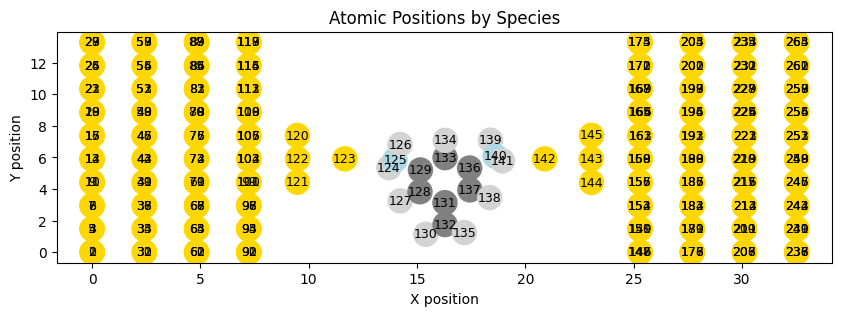

In [10]:
element_colors = {
    "Au": "gold",
    "C": "gray",
    'H': 'lightgray',
    'N': 'lightblue'
}

plot_atomic_positions_by_species(atoms, element_colors)

### Use the LCAO Hamiltonian to compute transmission function

In [15]:
H_lcao2 = H_lcao[None,...]
S_lcao2 = S_lcao[None,...]

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao2[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao2)
remove_pbc(device_basis, S_lcao2)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lcao2[0], S_lcao2[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='coupling',
                                 eta=eta)

# Calculate the transmission function T for each energy in the defined range
T = np.empty(energies.size)
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(E, Tref_dft, label="reference dft")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed dft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()

/tmp/ipykernel_61271/4253191868.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(hs_list_ii).shape)


ValueError: could not broadcast input array from shape (2,810,810) into shape (2,)

### Subdiagonalize C, N and H of LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

In [ ]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_sudiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_sudiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


### Compute and plot transmission function

In [ ]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sudiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sudiagonalized)
remove_pbc(device_basis, S_sudiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sudiagonalized[0], S_sudiagonalized[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='coupling',
                                 eta=eta)

# Calculate the transmission function T for each energy in the defined range
T = np.empty(energies.size)
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(E, Tref_dft, label="reference dft")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed dft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()

### Subdiagonalize only C and look at T(E) 

In [ ]:
# Define the species for subdiagonalization
SUBDIAG_SPECIES = ("C")

# Get the indices of atoms corresponding to the specified species in the basis
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices using the selected species
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the Hamiltonian and overlap matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the bridge region from the subdiagonalized Hamiltonian and overlap matrices
bridge_region_H_sub = H_sudiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_sudiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonalized overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')
plt.show()


### Compute and plot transmission function

In [ ]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sudiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sudiagonalized)
remove_pbc(device_basis, S_sudiagonalized)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)


# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_sudiagonalized[0],
    S_sudiagonalized[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(E, Tref_dft, label="reference dft")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed dft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C p and all N orbitals are considered to be the active region. 

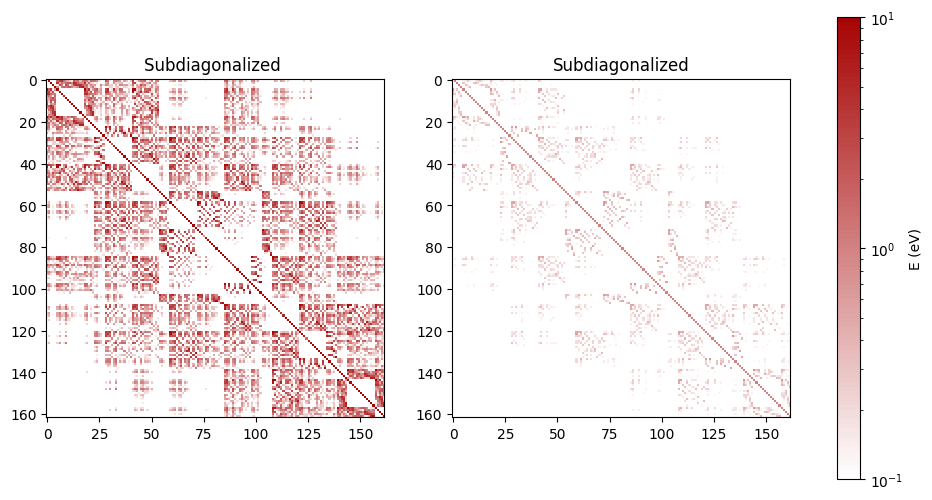

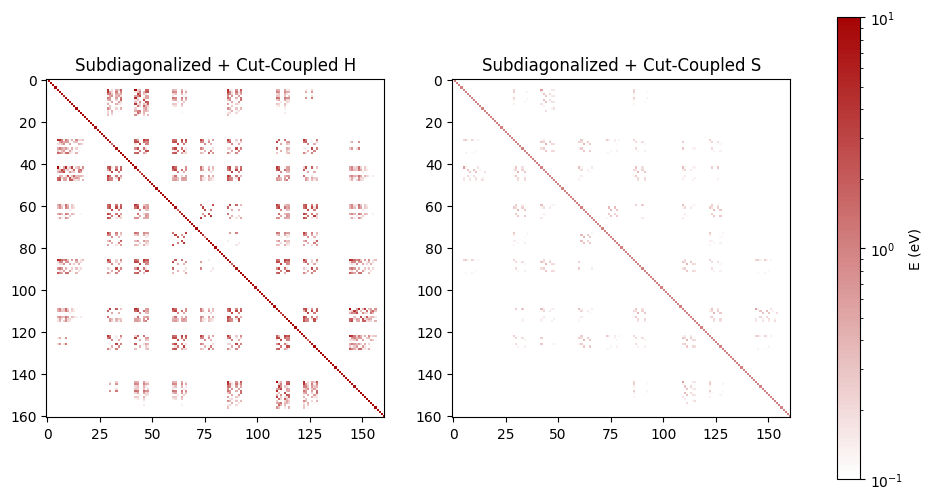

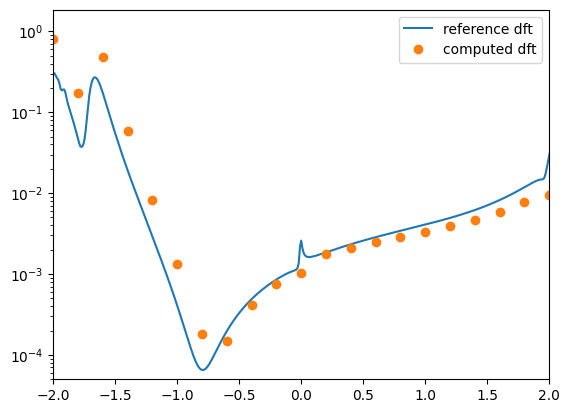

In [16]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sudiagonalized)
S_cutcoupled = deepcopy(S_sudiagonalized)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': [1, 2, 3, 5, 6, 7], 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_cut = S_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(H_sudiagonalized[0,bridge_start:bridge_end+1, bridge_start:bridge_end+1]), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized ")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_sudiagonalized[0,bridge_start:bridge_end+1, bridge_start:bridge_end+1]), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled[0],
    S_cutcoupled[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(E, Tref_dft, label="reference dft")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed dft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()

### Use C to subdiagonalize and look at the effect of cut-coupling where C p are considered to be the active region 

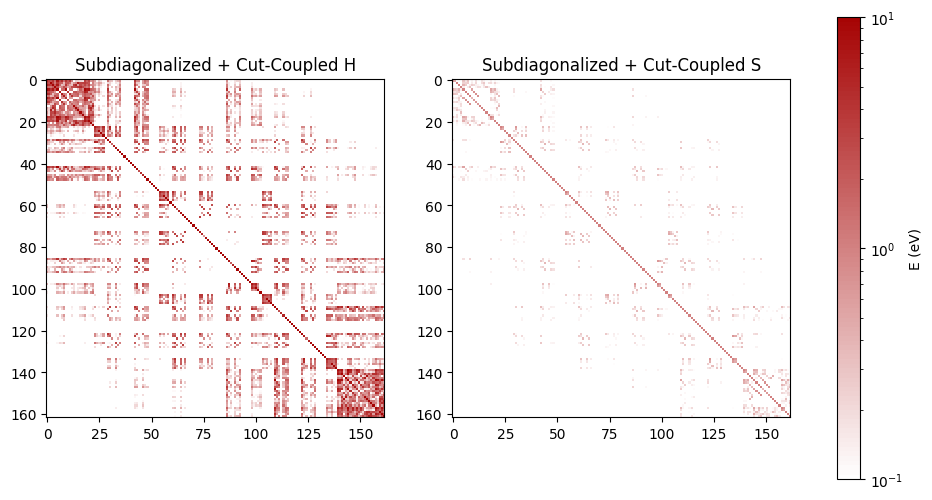

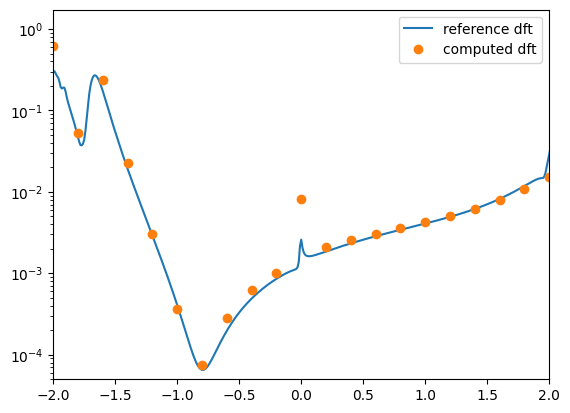

In [17]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sudiagonalized)
S_cutcoupled = deepcopy(S_sudiagonalized)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': [1, 2, 3, 5, 6, 7]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled[0],
    S_cutcoupled[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


# Plot the reference LCAO transmission data
plt.plot(E, Tref_dft, label="reference dft")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed dft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()